# Spam or Ham?

This is an example of using machine learning to classify emails as either spam or ham (not spam). The emails used to train this classifier are from [SpamAssassin's Public Corpus](https://spamassassin.apache.org/old/publiccorpus/). 

In [1]:
from bs4 import BeautifulSoup
from collections import Counter
import email
import joblib
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import re
import string

## 1 Preprocessing

In [2]:
def process_email(txt):
    """
    Takes a text file, opens it, and read in the contents. From there the header of the email is stripped, 
    since we are keeping this program simple. All letters are made lowercase and line breaks removed. HTML 
    is stripped. Numbers, urls, email addresses, and dollar signs are translated into other terms. All 
    other punctuation is stripped. I use a porter stemmer to convert words to their stems and build up the 
    word list that will later be converted to features.
    """
    if (type(txt) == bytes):
        msg_email = email.message_from_bytes(txt)
    else:
        msg_email = email.message_from_string(txt)
    word_list = []
    stemmer = PorterStemmer()
    msg = ''
    if msg_email.is_multipart():
        for part in msg_email.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()
                break
    else:
        msg = msg_email.get_payload()
        
    # Conver to all lowercase
    msg = msg.lower()
    
    # Remove line breaks
    msg = re.sub('\n', ' ', msg)
    msg = re.sub('\t', ' ', msg)
    
    # Stip HTML
    soup = BeautifulSoup(msg, 'lxml')
    msg = soup.get_text()
    
    # Convert numbers, urls, email addresses, and dollar signs
    msg = re.sub('[0-9]+', 'number', msg)
    msg = re.sub('(http|https)://[^\s]*', 'httpaddr', msg)
    msg = re.sub('[^\s]+@[^\s]+', 'emailaddr', msg)
    msg = re.sub('[$]+', 'dollar', msg)
    
    # Remove additional punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    msg = msg.translate(table)
    return msg

### 1.1 Load the text files

In [3]:
from sklearn.datasets import load_files

In [4]:
emails = load_files('data/')

In [5]:
emails.target_names

['ham', 'spam']

### 1.2 Split data into train and test sets

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(emails.data, emails.target)

In [8]:
X_train[0]

b'From fork-admin@xent.com  Sat Sep 21 10:43:16 2002\nReturn-Path: <fork-admin@xent.com>\nDelivered-To: yyyy@localhost.spamassassin.taint.org\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby jmason.org (Postfix) with ESMTP id 034D216F16\n\tfor <jm@localhost>; Sat, 21 Sep 2002 10:43:16 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Sat, 21 Sep 2002 10:43:16 +0100 (IST)\nReceived: from xent.com ([64.161.22.236]) by dogma.slashnull.org\n    (8.11.6/8.11.6) with ESMTP id g8L5NmC10269 for <jm@jmason.org>;\n    Sat, 21 Sep 2002 06:23:49 +0100\nReceived: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)\n    with ESMTP id E73CB294180; Fri, 20 Sep 2002 22:20:06 -0700 (PDT)\nDelivered-To: fork@spamassassin.taint.org\nReceived: from c007.snv.cp.net (h014.c007.snv.cp.net [209.228.33.242]) by\n    xent.com (Postfix) with SMTP id 0D4C929409C for <fork@xent.com>;\n    Fri, 20 Sep 2002 22:19:06 -0700

In [9]:
process_email(X_train[0])

' help me out here   you around  barely but dont call me shirley    im sleeping with one eye open  i wouldnt have married me if id known how extremely shallow my  politics are  the ward lurks in wisterias maze  cheers wayne   '

## 2 Support Vector Machine

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

### 2.1 Grid search and cross-validation on train set

We convert the emails into feature vectors which tell whether or not a word occurs in the email.

In [18]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=2000, 
                             preprocessor=process_email,
                             decode_error='ignore',
                             binary=True)),
    ('svc', SVC(kernel='linear')),
])
tuned_parameters = [{'svc__C': np.logspace(-2,2,5)}]
clf = GridSearchCV(pipeline, param_grid=tuned_parameters, 
                   scoring="f1", return_train_score=True,
                   verbose=10, n_jobs=3, cv=5)
clf.fit(X_train, y_train)
joblib.dump(clf, 'clf.gz')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] ............ svc__C=0.01, score=0.9230769230769231, total=  24.1s
[CV] svc__C=0.01 .....................................................
[CV] ............ svc__C=0.01, score=0.8923884514435695, total=  25.1s
[CV] svc__C=0.01 .....................................................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   47.7s


[CV] ............ svc__C=0.01, score=0.9128738621586475, total=  30.1s
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.9100391134289438, total=  25.2s
[CV] svc__C=0.1 ......................................................
[CV] ............. svc__C=0.1, score=0.9252577319587628, total=  20.8s
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.8851612903225806, total=  29.6s
[CV] svc__C=0.1 ......................................................
[CV] ............. svc__C=0.1, score=0.9203084832904884, total=  23.1s
[CV] svc__C=0.1 ......................................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  2.3min


[CV] ............. svc__C=0.1, score=0.9116517285531369, total=  27.4s
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.9220945083014048, total=  26.2s
[CV] svc__C=1.0 ......................................................
[CV] .............. svc__C=0.1, score=0.898477157360406, total=  22.2s
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9212903225806452, total=  24.8s
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9210866752910738, total=  27.2s
[CV] svc__C=1.0 ......................................................


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.2min


[CV] ............. svc__C=1.0, score=0.9058524173027989, total=  26.2s
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.9203084832904884, total=  25.1s
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.8993630573248408, total=  22.2s
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.9201030927835051, total=  22.1s
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.9135483870967741, total=  22.9s
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.9033078880407124, total=  25.6s
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=10.0, score=0.9159120310478654, total=  24.2s
[CV] svc__C=100.0 ....................................................


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  5.1min


[CV] ........... svc__C=100.0, score=0.9201030927835051, total=  26.2s
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=10.0, score=0.8968152866242038, total=  24.7s
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.9135483870967741, total=  25.3s
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.9033078880407124, total=  22.7s


[Parallel(n_jobs=3)]: Done  23 out of  25 | elapsed:  6.1min remaining:   31.8s


[CV] ........... svc__C=100.0, score=0.9159120310478654, total=  26.3s
[CV] ........... svc__C=100.0, score=0.8982188295165395, total=  21.3s


[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  6.5min finished


['clf.gz']

In [19]:
clf = joblib.load('clf.gz')
results = pd.DataFrame(clf.cv_results_)

### 2.2 Validation curve

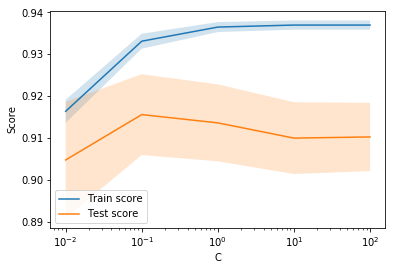

In [24]:
results.plot('param_svc__C', 'mean_train_score', label='Train score')
results.plot('param_svc__C', 'mean_test_score', label='Test score', ax=plt.gca())
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], 
                 alpha=0.2)
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.show()

### 2.3 Precision-recall curve

In [25]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)

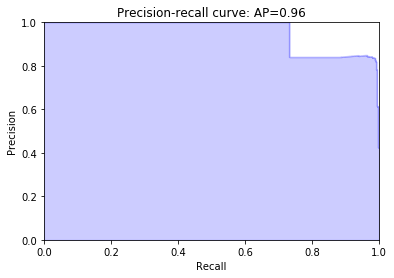

In [26]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

### 2.4 Evaluation of test set

In [27]:
y_true, y_pred = y_test, clf.predict(X_test)

In [28]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.94      0.96      1761
          1       0.84      0.98      0.90       577

avg / total       0.96      0.95      0.95      2338



In [29]:
print("Training accuracy: {0:.3}".format(clf.score(X_train, y_train)))

Training accuracy: 0.933


In [30]:
print("Test accuracy: {0:.3}".format(clf.score(X_test, y_test)))

Test accuracy: 0.904


### 2.5 Top predictors of spam

Clearly there is an issue of our model picking up words that are specific to this data set. `spamassassinsight` seems to be referring to `spamassassin-sightings`, an e-mail list that some users refer to. `deathtospamdeathtospamdeathtospam` comes from someone's signature. If we were to generalize our model, we would need a more general vocabulary list, drawn from a more diverse data set, or we can adjust `CountVectorizer` in the pipeline (or do a grid search over some additional hyperparameters).

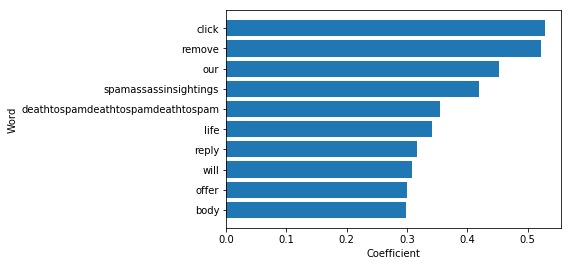

In [56]:
def plot_top(coef, names, n=10):
    coef_argsorted = np.argsort(coef)
    feature_names_array = np.array(names)
    words = []
    values = []
    for i in range(-n,0):
        words.append(names[coef_argsorted[i]])
        values.append(coef[coef_argsorted[i]])

    y = np.arange(n)
    plt.barh(y, values)
    plt.yticks(y, words)
    plt.xlabel('Coefficient')
    plt.ylabel('Word')
    plt.show()
    
plot_top(clf.best_estimator_.named_steps['svc'].coef_.toarray()[0], 
         clf.best_estimator_.named_steps['vect'].get_feature_names())